We shall introduce a Stabilized K-means cluster (Ref. https://doi.org/10.1007/978-3-030-10970-7_21)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import time

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Time taken by kmeans_plus_plus 0.01845574378967285 

Time taken by kmeans_plus_plus1 0.02018260955810547


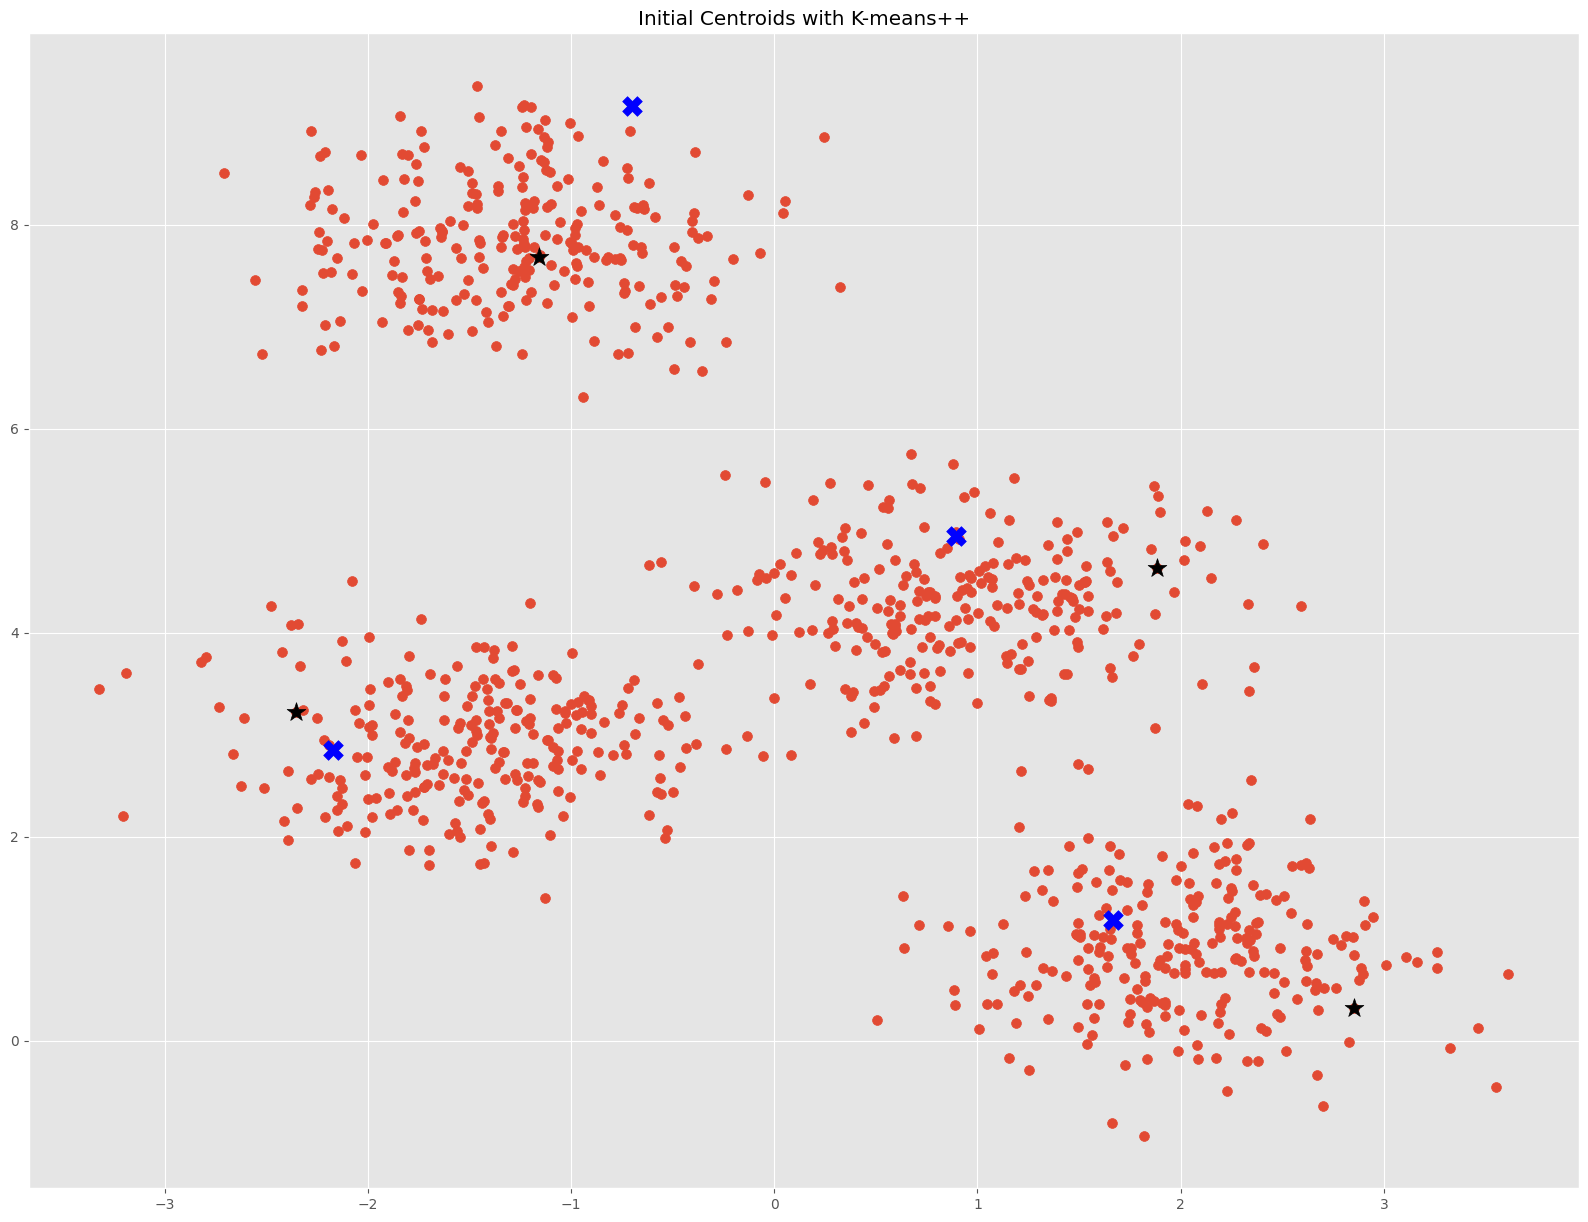

In [2]:
# K-means++ initialization
def kmeans_plus_plus(X, k):
    centroids = []
    first_centroid = X[np.random.choice(X.shape[0])]
    centroids.append(first_centroid)
    
    while len(centroids) < k:
        #print("len(centroids)=",len(centroids))
        distances = np.array([min([np.inner(c - x, c - x) for c in centroids]) for x in X])
        #print(distances, distances.sum())
        probabilities = distances / distances.sum()
        #print(probabilities)
        cumulative_probabilities = probabilities.cumsum()
        #print(cumulative_probabilities)
        r = np.random.rand()
        
        for i, p in enumerate(cumulative_probabilities):
            if r < p:
                centroids.append(X[i])
                #print("i=",i)
                break

    return np.array(centroids)

def kmeans_plus_plus1(X,k):
    centroids = []
    first_centroid = X[np.random.choice(X.shape[0])]
    centroids.append(first_centroid)
    
    while len(centroids) < k:
        #print("len(centroids)=",len(centroids))
        distances = np.array([min([np.inner(c - x, c - x) for c in centroids]) for x in X])
        #print(distances, distances.sum())
        probabilities = distances / distances.sum()
        #print(probabilities)
        #cumulative_probabilities = probabilities.cumsum()
        #print(cumulative_probabilities)
        i = np.random.choice(range(X.shape[0]),p=probabilities)
        centroids.append(X[i])
    return np.array(centroids)

# Generate sample data
X, y = make_blobs(n_samples=1000, centers=4, cluster_std=0.60, random_state=0)

# Number of clusters
k = 4

# Get initial centroids using K-means++
start = time.time()
initial_centroids = kmeans_plus_plus(X, k)
end = time.time()
print("Time taken by kmeans_plus_plus", end-start,"\n")

start = time.time()
initial_centroids1 = kmeans_plus_plus1(X, k)
end = time.time()
print("Time taken by kmeans_plus_plus1", end-start)

# Visualize initial centroids
plt.style.use("ggplot")
plt.figure(figsize=(20,15))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.scatter(initial_centroids[:, 0], initial_centroids[:, 1], s=200, c='blue', marker='X')
plt.scatter(initial_centroids1[:, 0], initial_centroids1[:, 1], s=200, c='black', marker='*')
plt.title("Initial Centroids with K-means++")
plt.show()


In [3]:
def assign_clusters(X, centroids):
    clusters = []
    for x in X:
        distances = [np.linalg.norm(x - centroid) for centroid in centroids]
        cluster = np.argmin(distances)
        clusters.append(cluster)
    return np.array(clusters)

# Update centroids to the mean of assigned points
def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        points_in_cluster = X[clusters == i]
        if points_in_cluster.size > 0:
            new_centroid = points_in_cluster.mean(axis=0)
        else:
            # Handle the case where a cluster has no points assigned
            new_centroid = X[np.random.choice(X.shape[0])]
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

# Stabilize Update centroids to the mean of assigned points (Reference:https://doi.org/10.1007/978-3-030-10970-7_21)
def stabilize_update_centroids(X, centroids, clusters, k):
    new_centroids = []
    
    m = X.shape[0]
    for i in range(k):
        ck=0
        for j in range(m):
            if clusters[j] == i:
                ck+=X[j]
            else:
                ck+=centroids[i]
        ck /= m
        new_centroids.append(ck)
    return np.array(new_centroids)

# K-means algorithm
def kmeans(X, k, max_iterations=100, tol=1e-4):
    #centroids = kmeans_plus_plus(X, k)
    centroids = kmeans_plus_plus1(X, k)
    #new_centroids=centroids
    for i in range(max_iterations):
        clusters = assign_clusters(X, centroids)
        #print("Iteration ",i, "Clusters are ", clusters)
        new_centroids = update_centroids(X, clusters, k)
        #new_centroids = stabilize_update_centroids(X, new_centroids, clusters, k)
        #print("iteration =",i, "norm is ", np.sum(np.linalg.norm(new_centroids - centroids, axis=1)),np.linalg.norm(new_centroids - centroids))
        
        # Check for convergence
        if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
            print("Converge at iteration", i)
            break
        
        centroids = new_centroids
    return centroids, clusters

Converge at iteration 3
Time taken by kmeans 0.11127400398254395


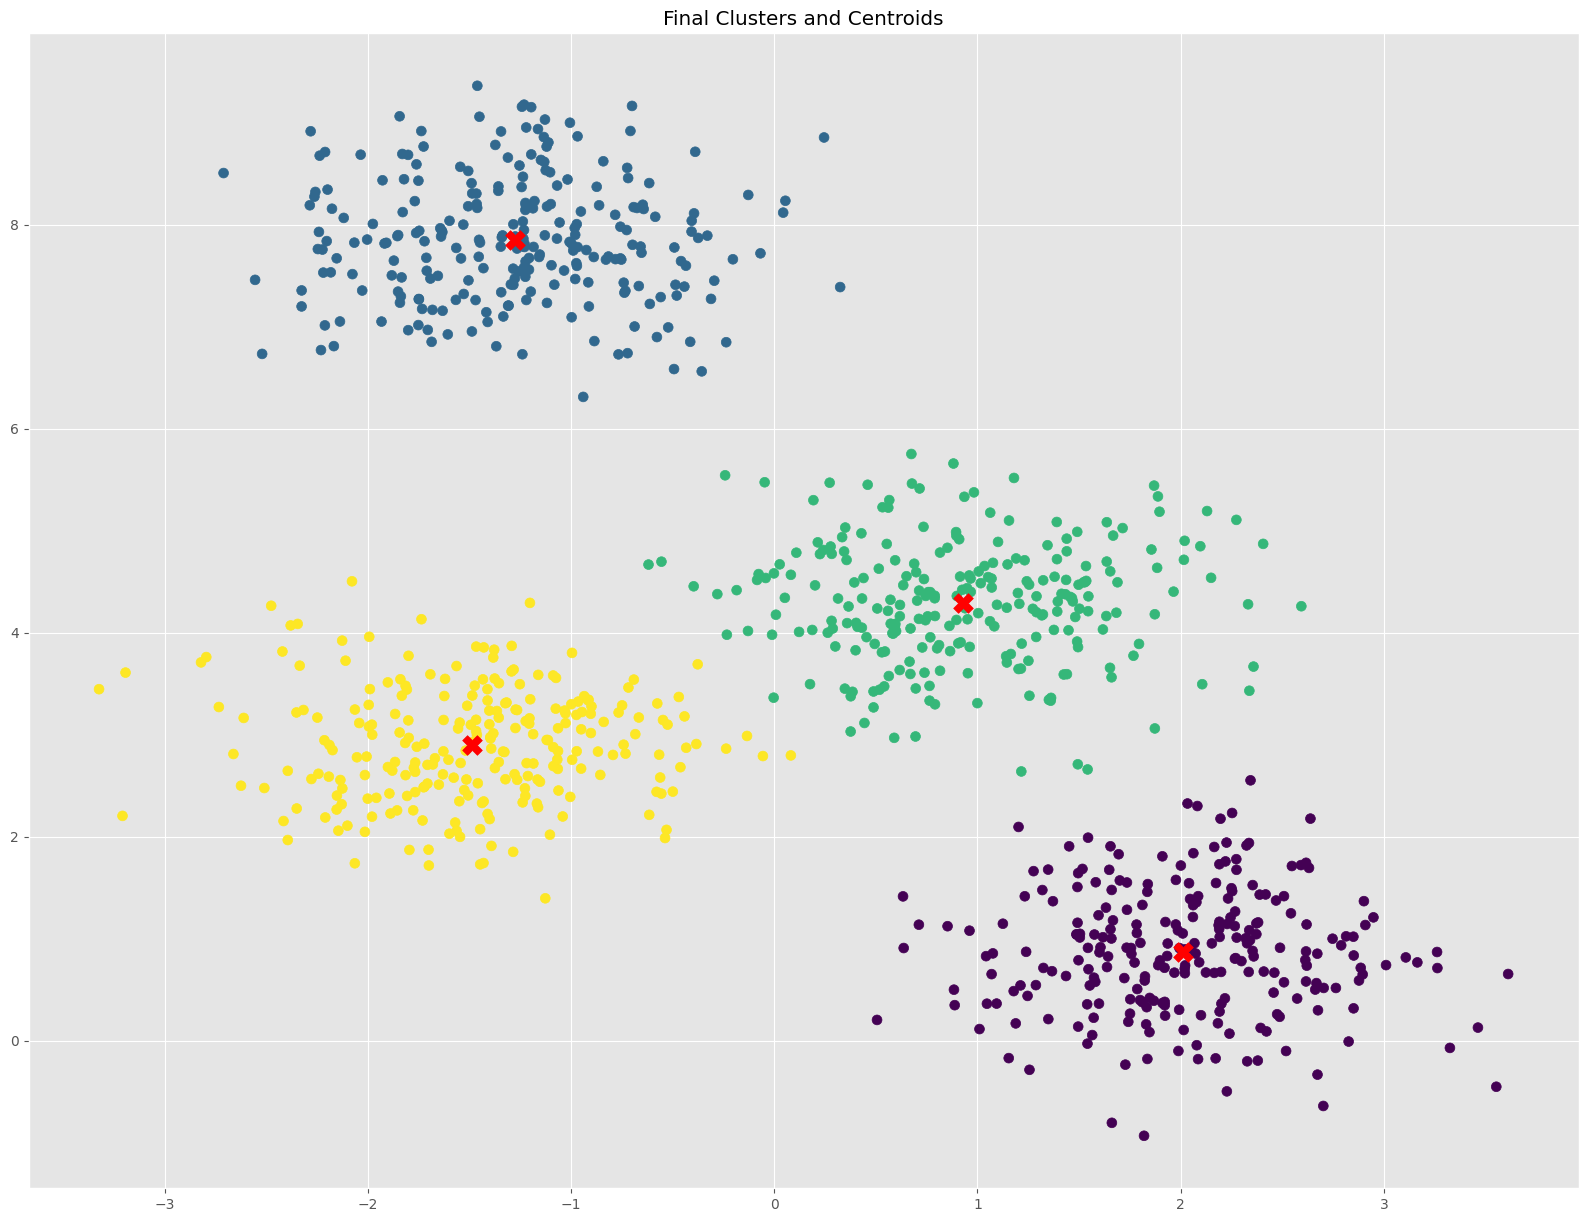

In [4]:
# Run K-means algorithm
start=time.time()
centroids, clusters = kmeans(X, k)
end=time.time()
print("Time taken by kmeans", end-start)


# Visualize final clusters and centroids
plt.figure(figsize=(20,15))
plt.scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X')
plt.title("Final Clusters and Centroids")
plt.show()

In [5]:
# The Stabilized K-Means-Algorithm (Ref: https://doi.org/10.1007/978-3-030-10970-7_21)
"""Jäschke, A., Armknecht, F.: Unsupervised machine learning on encrypted data. In:
Cid, C., Jacobson Jr., M.J. (eds.) Selected Areas in Cryptography – SAC 2018 (15-
17 August, Calgary, Canada), Lecture Notes in Computer Science, vol. 11349, pp.
453–478. Springer, Cham (2019),"""
def stabilizedkmeans(X, k, max_iterations=100, tol=1e-4):
    centroids = kmeans_plus_plus(X, k)
    
    for i in range(max_iterations):
        clusters = assign_clusters(X, centroids)
        #print("Iteration ",i, "Clusters are ", clusters)
        new_centroids = stabilize_update_centroids(X, centroids, clusters, k)
        #print("iteration =",i, "norm is ", np.sum(np.linalg.norm(new_centroids - centroids, axis=1)),np.linalg.norm(new_centroids - centroids))
        
        # Check for convergence
        if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
            print("Converge at iteration", i)
            break
        
        centroids = new_centroids
    return centroids, clusters

Converge at iteration 30
Time taken by Stabilized kmeans 0.8466305732727051


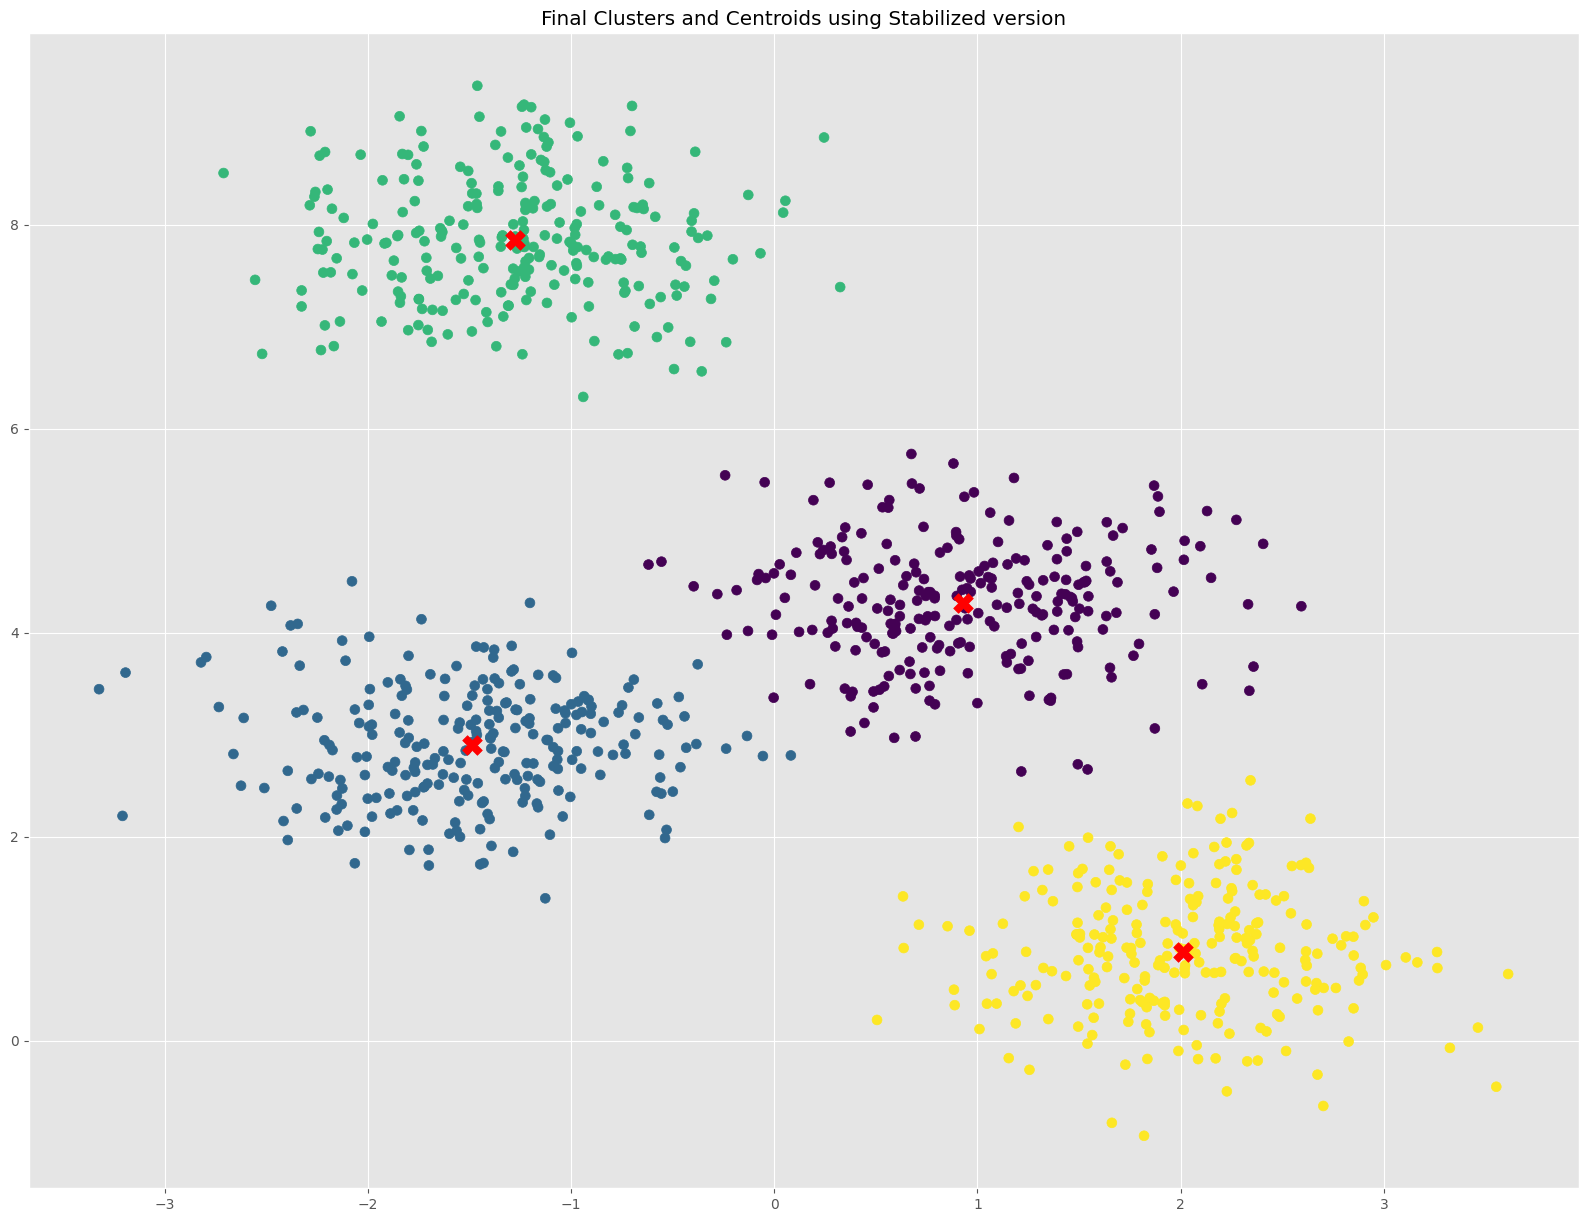

In [6]:
# Stabilized Run K-means algorithm
start=time.time()
stablecentroids, stableclusters = stabilizedkmeans(X, k)
end=time.time()
print("Time taken by Stabilized kmeans", end-start)


# Visualize final clusters and centroids
plt.figure(figsize=(20,15))
plt.scatter(X[:, 0], X[:, 1], c=stableclusters, s=50, cmap='viridis')
plt.scatter(stablecentroids[:, 0], stablecentroids[:, 1], s=200, c='red', marker='X')
plt.title("Final Clusters and Centroids using Stabilized version")
plt.show()